<a href="https://colab.research.google.com/github/Nutsudapenpong/AIprototype2022/blob/main/Densenet_parasite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
%cd /content/drive/MyDrive/New_yolo/Densenet

/content/drive/MyDrive/New_yolo/Densenet


In [3]:
#!wget http://www.vision.caltech.edu/Image_Datasets/Caltech256/256_ObjectCategories.tar

--2022-06-11 09:44:38--  http://www.vision.caltech.edu/Image_Datasets/Caltech256/256_ObjectCategories.tar
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|185.199.108.153|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-06-11 09:44:38 ERROR 404: Not Found.



In [42]:
#a library to simplify training
!pip install pytorch-ignite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#for unzipping tar files
#!tar -xf 256_ObjectCategories.tar

In [43]:
import torch
import torchvision
from torchvision import datasets, transforms #For loading our dataset
from torch import nn, optim # NN module and optimizers
from torch.nn import functional as F # Certain function, like sigmoid and tanh
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models # This is where we get our model.

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#For retina displays only

In [45]:
import numpy as np

In [46]:
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix

In [47]:
#writing a helper function to load data in
def get_data_loaders(data_dir, batch_size):
  transform = transforms.Compose([transforms.Resize(255), 
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor()])
  #Changing the image so that we can use it in our model
  all_images = datasets.ImageFolder(data_dir, transform=transform)
  train_images_len = int(len(all_images) * 0.75) #75% of images will be trained
  valid_images_len = int((len(all_images) - train_images_len)*0.5)
  test_images_len = int((len(all_images) - train_images_len - valid_images_len))
  train_data, val_data, test_data = random_split(all_images, [train_images_len, valid_images_len, test_images_len])
  train_loader = DataLoader(train_data, batch_size=batch_size)
  test_loader = DataLoader(test_data, batch_size=batch_size)
  val_loader = DataLoader(val_data, batch_size=batch_size)
  return (train_loader, val_loader, test_loader), all_images.classes

In [48]:
(train_loader, val_loader, test_loader), classes = get_data_loaders("/content/drive/MyDrive/New_yolo/Densenet/Parasite_eggs", 64)

In [11]:
print(classes)

['Ascaris', 'Echinostoma', 'Hookworm', 'MIF', 'OV', 'Taenia', 'Trichuris']


In [49]:
#build a helper function to format the text
#Goal is to turn a string like 007.bat to bat
import re
def formatText(string):
  string = string[4:]
  return string.replace("_", " ")
print(formatText(classes[0]))

ris


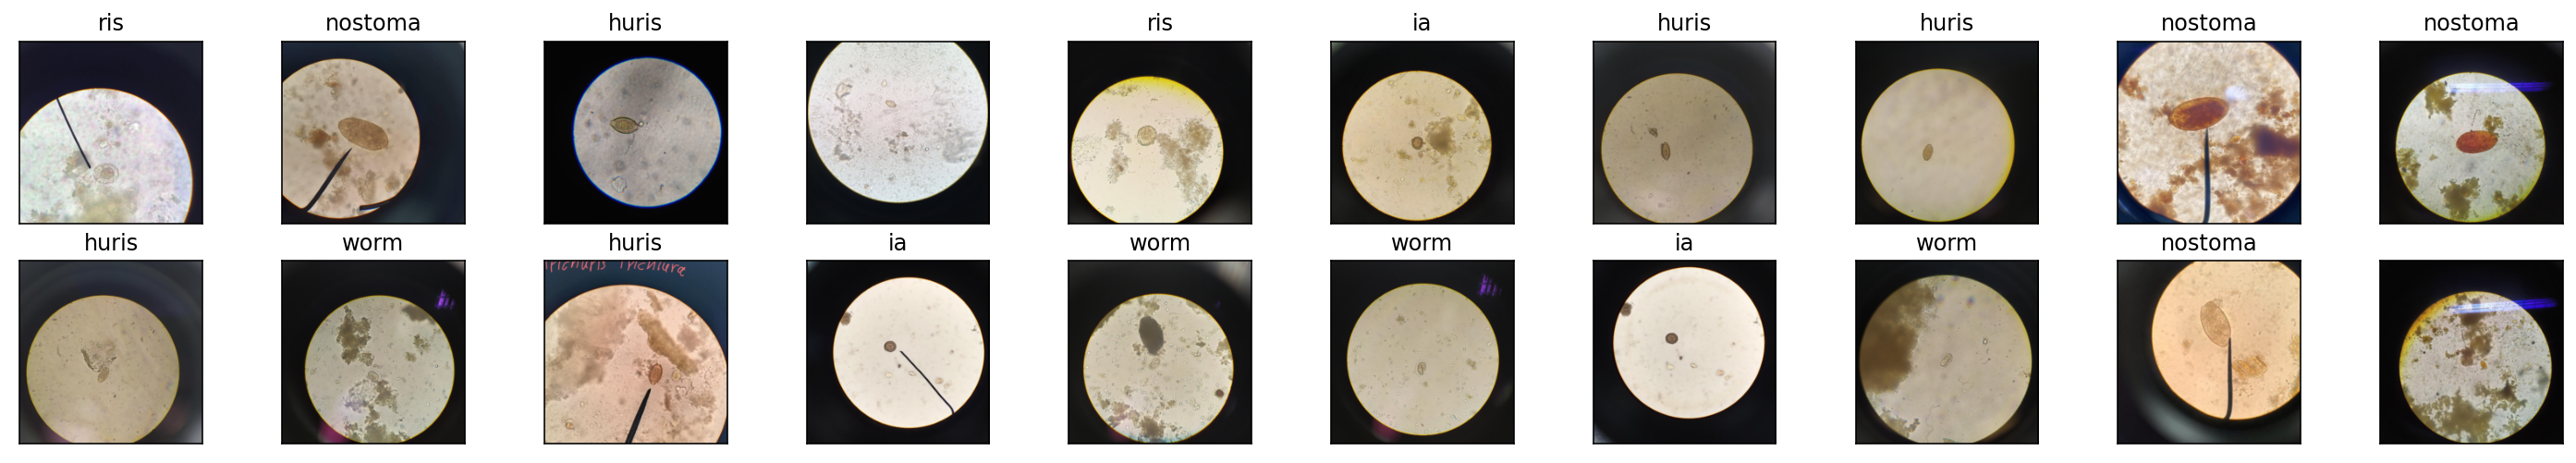

In [50]:
#Display training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

fig=plt.figure(figsize=(25,4))
for idx in np.arange(20): #only 20 images
  ax = fig.add_subplot(2, 20/2, idx + 1, xticks=[], yticks=[])
  #We don't need axes for the images
  plt.imshow(np.transpose(images[idx], (1, 2, 0)))
  ax.set_title(formatText(classes[labels[idx]]))

#training

In [51]:
#loading model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [52]:
model = models.densenet201(pretrained=True) #using densenet 201

In [53]:
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [54]:
#We need to change the last layer to have a output shape of 257
print(model.classifier.in_features)
print(model.classifier.out_features)

1920
1000


In [55]:
for param in model.parameters():
  param.requires_grad = False #We are freezing the model since it was trained on imageet and we do not need to train that part agian 

In [56]:
n_inputs = model.classifier.in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier = last_layer
print(model.classifier.out_features)

7


In [57]:
#Moving our model to GPU
model = model.to(device)

In [58]:
#Defining our optimizer and loss function
criterion = nn.CrossEntropyLoss() #This is our loss function
optimizer = optim.Adam(model.classifier.parameters()) #Feed parameters to the model

In [59]:
#Training model
training_history = {'accuracy':[], 'loss':[]}
validation_history = {'accuracy':[], 'loss':[]}

In [60]:
#Now we will use PyTorch Ignite's feaures
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(model,
                                       device=device,
                                       metrics={
                                           'accuracy':Accuracy(),
                                           'loss': Loss(criterion),
                                           'cm':ConfusionMatrix(len(classes))}
                                      )
#Creating even handlers to show our training progress
@trainer.on(Events.ITERATION_COMPLETED)
def log_a_dot(engine):
  print(".", end="")

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
  evaluator.run(train_loader)
  metrics = evaluator.state.metrics
  accuracy = metrics['accuracy']*100
  loss = metrics['loss']
  training_history['accuracy'].append(accuracy)
  training_history['loss'].append(loss)
  print()
  print(f"Training results - Epoch: {trainer.state.epoch} Avg accuracy: {accuracy} Loss: {loss}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
  evaluator.run(val_loader)
  metrics = evaluator.state.metrics
  accuracy = metrics['accuracy']*100
  loss = metrics['loss']
  validation_history['accuracy'].append(accuracy)
  validation_history['loss'].append(loss)
  print()
  print(f"Validation results - Epoch: {trainer.state.epoch} Avg accuracy: {accuracy} Loss: {loss}")

In [62]:
trainer.run(train_loader, max_epochs=5)

...........
Training results - Epoch: 3 Avg accuracy: 62.402496099843994 Loss: 1.2923870592519013

Validation results - Epoch: 3 Avg accuracy: 53.271028037383175 Loss: 1.3819828211704148
...........
Training results - Epoch: 4 Avg accuracy: 65.05460218408736 Loss: 1.1618061988104524

Validation results - Epoch: 4 Avg accuracy: 56.074766355140184 Loss: 1.2942691696024387
...........
Training results - Epoch: 5 Avg accuracy: 71.60686427457098 Loss: 1.0426110135225721

Validation results - Epoch: 5 Avg accuracy: 64.48598130841121 Loss: 1.2028780072648948


State:
	iteration: 55
	epoch: 5
	epoch_length: 11
	max_epochs: 5
	output: 1.649694800376892
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

Testing

Text(0.5, 1.0, 'Validation loss')

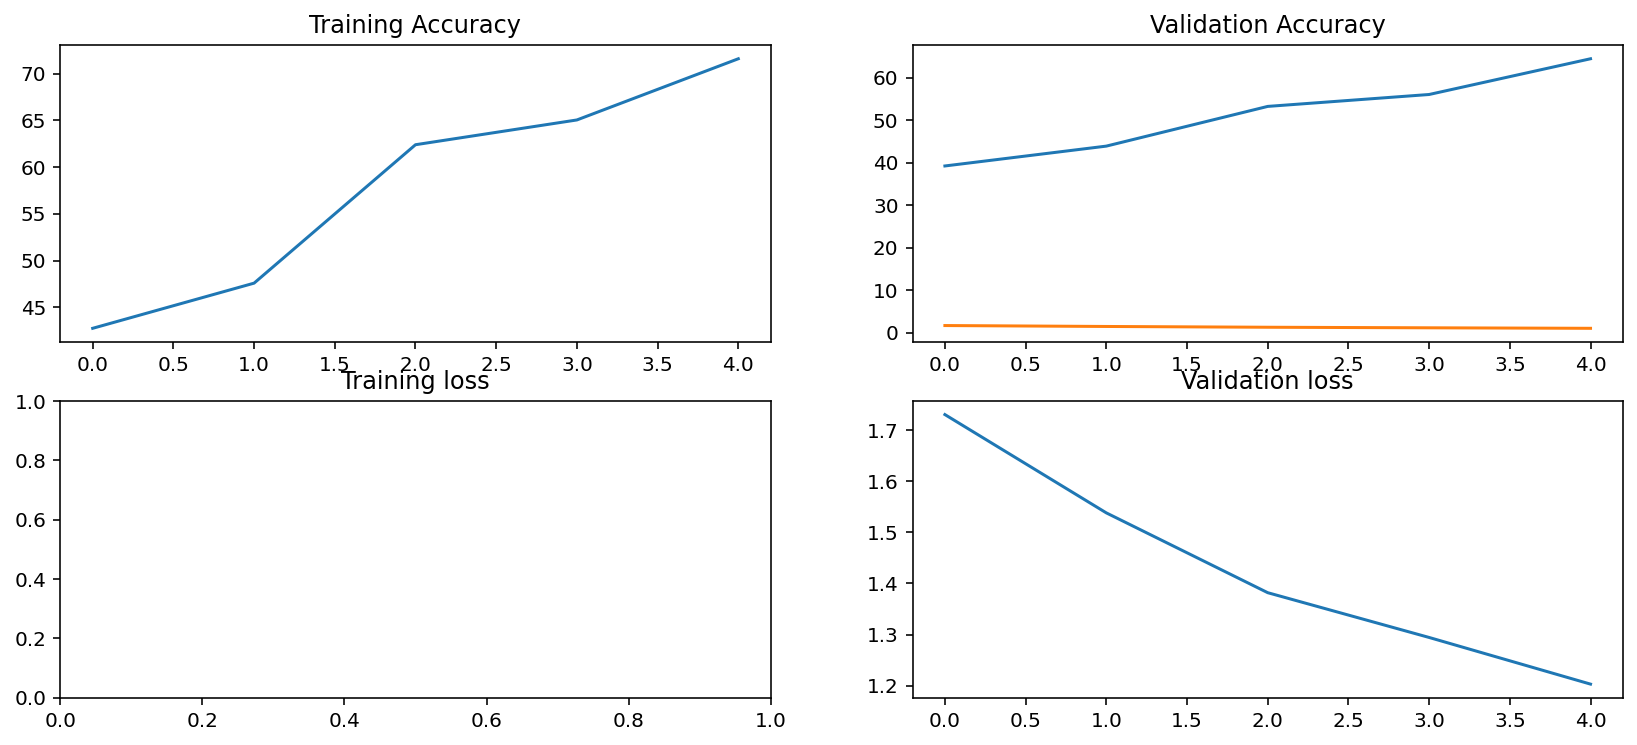

In [64]:
fig, axs = plt.subplots(2,2)
fig.set_figheight(6)
fig.set_figwidth(14)
axs[0, 0].plot(training_history["accuracy"])
axs[0, 0].set_title("Training Accuracy")
axs[0, 1].plot(validation_history["accuracy"])
axs[0, 1].set_title("Validation Accuracy")
axs[0, 1].plot(training_history["loss"])
axs[1, 0].set_title("Training loss")
axs[1, 1].plot(validation_history["loss"])
axs[1, 1].set_title("Validation loss")

In [67]:
test_loss = 0.0
class_correct = np.zeros((len(classes)))
class_total = np.zeros((len(classes)))
model.eval() #Setting model to evaluation mode

for data, target in test_loader:
  if torch.cuda.is_available():
    data, target = data.cuda(), target.cuda()
  output = model(data)
  loss = criterion(output, target)
  test_loss += loss.item() * data.size(0)
  _, pred = torch.max(output, 1)
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
  if len(target) == 64:
    for i in range(64):
      label = target.data[i]
      class_correct[label] += correct[i].item()
      class_total[label] += 1
test_loss /= len(test_loader.dataset)
print("Test Loss: {:.6f}\n".format(test_loss))

for i in range(len(classes)):
  if class_total[i] > 0:
    print("Test Accuracy of {}: {} ({}/{})".format(
        classes[i], 100*class_correct[i] / class_total[i],
        np.sum(class_correct[i]), np.sum(class_total[i])
    ))
  else:
    print("Test Accuracy of {}: N/A (since there are no examples)".format(classes[i]))
print("Test Accuracy Overall: {} ({}/{})".format(
        100*np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)
    ))

Test Loss: 1.250218

Test Accuracy of Ascaris: 30.0 (3.0/10.0)
Test Accuracy of Echinostoma: 50.0 (3.0/6.0)
Test Accuracy of Hookworm: 100.0 (1.0/1.0)
Test Accuracy of MIF: 83.33333333333333 (5.0/6.0)
Test Accuracy of OV: 33.333333333333336 (4.0/12.0)
Test Accuracy of Taenia: 82.3529411764706 (14.0/17.0)
Test Accuracy of Trichuris: 58.333333333333336 (7.0/12.0)
Test Accuracy Overall: 57.8125 (37.0/64.0)
